# The Hello World program of Quantum Computing
This is the classic Mermin experiment which allows a simple test of Quantum Mechanics. For superconducting qubits this was first done in 2010 in this [paper](https://doi.org/10.1038/nature09416) or the arXiv [version](https://arxiv.org/abs/1004.4324). 

Lets assume that we have three qubits and each qubit can either have the $X$ or $Y$ operator measured and must give a value of of $\pm 1$. We now imagine that we need to play a game and set the value of X or Y such that the following four conditions are met. 

$$
XXY=1
$$
$$
XYX=1
$$
$$
YXX=1
$$
$$
YYY=-1
$$

where $XXY$ is short hand for $Y$ on qubit $1$, $X$ on qubit $2$ and $X$ on qubit $3$. Try to see if you can assign all 6 operators either a $\pm1$. It turns out you can't and a easy way to see this is each operator appears twice on the LHS of the equations so the product of all equations gives 1 for the left hand side and -1 for the right hand side. 

However, there is a quantum state which if created and measured would meet these four conditions. Without loss of generality we can define what is known as the Mermin Operator 

$$ 
M = XXY+XYX+YXX-YYY
$$ 

and it is possible to measured an expectation value of 4 using a quantum state, thereby realizing the game above.

Lets start by setting up the programming environment and then we go through the 4 steps:
- **Step 1** Map the problem to a Quantum Native format (Set of Operators, and a set of Quantum Circuits)
- **Step 2** Optimize the circuits and operators to run on quantum hardware
- **Step 3** Execute using a quantum primitive function (estimator or sampler)
- **Step 4** Post-processing of the results to return either a plot or the answer


## **Step 0**: Setup

In [7]:
import numpy as np

# Qiskit Quantum Circuit
from qiskit import QuantumCircuit

# Qiskit Operator form
from qiskit.quantum_info import SparsePauliOp

# Import Qiskit packages
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum", instance="executive/internal/main")

# Define backend
use_real = False

if use_real:
    backend = service.backend('ibmq_kolkata')
else:
    backend = service.backend('ibmq_qasm_simulator')

## **Step 1** Map the problem to a Quantum Native format (Set of Operators, and a set of Quantum Circuits)
Here we define the Mermin operator to be measured and the trial quantum circuits to be prepared to find the quantum circuit that maximizes the Mermin operator. The output of this step should be an operator to be measured and a quantum circuit

In [8]:
number_of_phases = 20
phases = np.linspace(0, 2*np.pi, number_of_phases)
mermin = SparsePauliOp.from_list([("XXY", 1), ("XYX", 1), ("YXX", 1), ("YYY", -1)])
print(mermin)

SparsePauliOp(['XXY', 'XYX', 'YXX', 'YYY'],
              coeffs=[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j])


In [9]:
from qiskit.circuit import Parameter

theta = Parameter('theta')
qc_example = QuantumCircuit(3)
qc_example.h(0) # generate superposition
qc_example.p(theta, 0) # add quantum phase
qc_example.cx(0, 1) # condition 1st qubit on 0th qubit
qc_example.cx(0, 2) # condition 2nd qubit on 0th qubit
print(qc_example)

     ┌───┐┌──────────┐          
q_0: ┤ H ├┤ P(theta) ├──■────■──
     └───┘└──────────┘┌─┴─┐  │  
q_1: ─────────────────┤ X ├──┼──
                      └───┘┌─┴─┐
q_2: ──────────────────────┤ X ├
                           └───┘


## **Step 2**: Optimize the circuits and the operators to be measured

The Native set for the IBM Hardware is control-z, sqrt-x and a rotation around the z-axis [cz, sx, rz] and we have assumed the qubits are in a line. Here we have used the default pass-managers but set the optimization_level to 3 which should find the optimial version of this circuit for the IBM hardware. 

In [10]:
from qiskit.compiler import transpile
qc_ibm = transpile(qc_example, basis_gates = ['cz', 'sx', 'rz'],  coupling_map =[[0, 1], [1, 2]], optimization_level=3)
print(qc_ibm)

         ┌─────────┐┌────┐ ┌───────┐                 ┌────┐┌─────────┐»
q_1 -> 0 ┤ Rz(π/2) ├┤ √X ├─┤ Rz(π) ├───────────────■─┤ √X ├┤ Rz(π/2) ├»
         ├─────────┤├────┤┌┴───────┴┐┌───────────┐ │ └────┘└─────────┘»
q_0 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤ Rz(theta) ├─■───■──────────────»
         ├─────────┤├────┤└┬───────┬┘└───────────┘     │      ┌────┐  »
q_2 -> 2 ┤ Rz(π/2) ├┤ √X ├─┤ Rz(π) ├───────────────────■──────┤ √X ├──»
         └─────────┘└────┘ └───────┘                          └────┘  »
«                    
«q_1 -> 0 ───────────
«                    
«q_0 -> 1 ───────────
«         ┌─────────┐
«q_2 -> 2 ┤ Rz(π/2) ├
«         └─────────┘


In [11]:
qc_ibm.layout.initial_layout

Layout({
1: Qubit(QuantumRegister(3, 'q'), 0),
0: Qubit(QuantumRegister(3, 'q'), 1),
2: Qubit(QuantumRegister(3, 'q'), 2)
})

In [12]:
qc_ibm.layout

TranspileLayout(initial_layout=Layout({
1: Qubit(QuantumRegister(3, 'q'), 0),
0: Qubit(QuantumRegister(3, 'q'), 1),
2: Qubit(QuantumRegister(3, 'q'), 2)
}), input_qubit_mapping={Qubit(QuantumRegister(3, 'q'), 0): 0, Qubit(QuantumRegister(3, 'q'), 1): 1, Qubit(QuantumRegister(3, 'q'), 2): 2}, final_layout=None)

In [13]:
qc_ibm.layout.input_qubit_mapping

{Qubit(QuantumRegister(3, 'q'), 0): 0,
 Qubit(QuantumRegister(3, 'q'), 1): 1,
 Qubit(QuantumRegister(3, 'q'), 2): 2}

In [14]:
qc_ibm.layout.final_layout

** FIX ** I really see a bug here - we need to have the final_layout returned always. I have no idea what the input_qubit_mapping is.

We need a function that 

mermin_ibm = transpile_operator(mermin, layout )

In [15]:
mermin_ibm = mermin

## **Step 3**: Execute using a quantum primitive function (estimator or sampler)
Here we use the estimator primitve by sending all phases and the Mermin operator to the quantum hardware.

In [16]:
options = Options()
options.resilience_level = 1
options.execution.shots = 1000

# Run the experiments

estimator = Estimator(session=backend, options=options)
    
job = estimator.run(circuits=[qc_ibm]*number_of_phases, 
                    observables=[mermin_ibm]*number_of_phases, parameter_values=[[ph] for ph in phases])

from helpers import check_job_status
values = check_job_status(job,'mermin')

mermin.picke


## **Step 4**: Post-processing of the results to return either a plot or the answer
Here we plot the output so the user can view when a measured value is greater than +2 or less than -2.

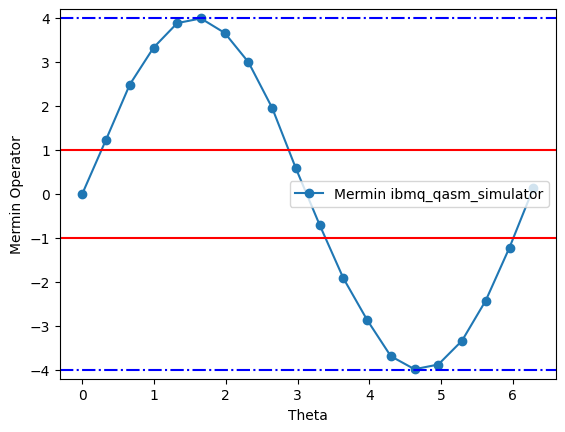

In [17]:
import matplotlib.pyplot as plt

plt.plot(phases, values, 'o-', label='Mermin %s'%(backend.name))

plt.axhline(y=1, color='r', linestyle='-')
plt.axhline(y=-1, color='r', linestyle='-')
plt.axhline(y=4, color='b', linestyle='-.')
plt.axhline(y=-4, color='b', linestyle='-.')
plt.ylim(-4.2,4.2)
plt.xlabel('Theta')
plt.ylabel('Mermin Operator')
plt.legend(loc="center right")
plt.show()